In [40]:
#% pip install openpyxl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from globals import glob
from utilities import plot_scatter, prepare_database
import sys
sys.path.append("../tools/")
import _db_tools as db
####Helper Functions####
def RyR(df: pd.DataFrame) -> pd.DataFrame:
    """ Calculates the RyR values for both fibers and provides a qualitative evaluation for each value.
    Parameters:
    - df (pd.DataFrame): The input DataFrame containing fiber measurements.
    Returns:
    Tuple[pd.DataFrame, pd.DataFrame]: A tuple containing two DataFrames:
    - The first DataFrame (dfx) contains the RyR values for fiber x.
    - The second DataFrame (dfy) contains the RyR values for fiber y.
    For each fiber, the function calculates the RyR (Range-to-Range) values as a percentage of the standard deviation
    and the difference between the last and second-to-last columns in the input DataFrame. It then prints a qualitative
    evaluation of each RyR value for both fibers.
    Qualitative Evaluation:
    - "Correct" if RyR <= 10.
    - "Low fail" if 10 < RyR <= 25.
    - "High fail" if RyR > 25."""
    i = 0; df_RyR = [] #Preallocate a counter and an empty dataframe where to add the rows
    std = df.iloc[:, :-2].std(axis=1) #Standard deviation for each row, excluding limits
    for index in range(df.shape[0]):
        i+= 1
        RyR = (6*std.iloc[index]/(df.iloc[index,-1]-df.iloc[index,-2]))*100 #Calculates RyR for the whole dataframe
        df_RyR.append(float(RyR)) #Adds the values of RyR to a ndarray
    df_RyR = pd.DataFrame(df_RyR) #Builds a new dataframe with the RyR values
    x_fiber = df_RyR[df_RyR.index % 2 != 0] #Indexes the fiber x RyR values in a new dataframe
    y_fiber = df_RyR[df_RyR.index % 2 == 0] #Indexes the fiber y RyR values in a new dataframe
    dfx = pd.DataFrame(x_fiber).reset_index(drop=True) #Resets row index
    dfy = pd.DataFrame(y_fiber).reset_index(drop=True) #Resets row index
    for i, _ in enumerate(range(dfx.shape[0])): #Prints the dataframe for fiber x row by row indexing with the counter
        Pass = "Correct" if dfx.iloc[i, 0] <= 10 else ("Low fail" if 10 <= dfx.iloc[i, 0] <= 25 else "High fail")
        print(f'RyR Guide fbx {dfx.index[i]+1}: ' + str(dfx.iloc[i, 0]) +' %' + ' Status: ' + Pass)
    print("")
    for i, _ in enumerate(range(dfy.shape[0])): #Prints the dataframe for fiber y row by row
        Pass = "Correct" if dfy.iloc[i, 0] <= 10 else ("Low fail" if 10 <= dfy.iloc[i, 0] <= 25 else "High fail")
        print(f'RyR Guide fby {dfy.index[i]+1}: ' + str(dfy.iloc[i, 0]) +' %' + ' Status: ' + Pass)
    return dfx, dfy

def z_score_filter(df, threshold):
    """Applies a z-score filter to a DataFrame, removing values that do not meet the specified threshold.
    Parameters:
    - df (pd.DataFrame): The input DataFrame containing the measurements and limits.
    - threshold (float): The z-score threshold. Values exceeding this threshold will be replaced with NaN.
    Returns:
    pd.DataFrame: A new DataFrame with values that pass the z-score filter, while retaining the original limits columns.
    For each row in the input DataFrame, the function calculates the z-scores for the measurement values and
    replaces values with z-scores greater than the specified threshold with NaN. The original limits columns are retained.
    """
    rows = []
    measures = df.iloc[:, :-2]  #Indexes the measurements
    limits = df.iloc[:, -2:]  #Indexes the limits
    for row_idx in range(measures.shape[0]):  # Iterates over the rows
        row = measures.iloc[row_idx, :]
        if row.std() == 0: #If the standard deviation is zero, don't calculate z-scores and keep the original values
            filtered_row = row
        else:
            z_scores = (row - row.mean()) / row.std()  #Calculates the z-score
            filtered_row = np.where(abs(z_scores) <= threshold, row, np.nan)  #Applies the threshold as a filter
        rows.append(filtered_row)
    filtered_df = pd.DataFrame(rows)  #Builds a new DataFrame
    filtered_df = pd.concat([filtered_df, limits], axis=1)  #Adds back the columns
    return filtered_df

In [20]:
#Data preparation
dbh = db.SQLite_Data_Extractor("database.db") #Connect to the database
measurements = dbh.retrieve(glob.tooling) #Get the desired tooling data
limits = dbh.retrieve(glob.tooling+"_limits") #Get the desired tooling data
dbh.close_conn() 

Database *database.db* found in: c:\Users\lucio\Desktop\Code\Python_Eiit_RyR\a2_RyR_Analyser\database\database.db
Table *Test* retrieved succesfully.
Table *Test_limits* retrieved succesfully.
Closed connection to: c:\Users\lucio\Desktop\Code\Python_Eiit_RyR\a2_RyR_Analyser\database\database.db


RyR calculation

In [26]:
#Slice the dataframe to obtain only the measures and limits for each fiber
measurements_and_limits = pd.concat([measurements, limits], axis=1) #Gets both the measure and limits
""" df_plus_limits = df_plus_limits.reset_index(drop=True) #Resets the rows index to start in zero again
df_plus_limits.columns = range(df_plus_limits.shape[1]) #Resets the columns index to start in zero again """
#Generate a RyR for each fiber in every scale
RyRx, RyRy = RyR(measurements_and_limits)

RyR Guide fbx 1: 1.0271586502546768e-12 % Status: Correct
RyR Guide fbx 2: 34.945243632260166 % Status: High fail
RyR Guide fbx 3: 1.2004965792554727 % Status: Correct
RyR Guide fbx 4: 1.2405240713107974 % Status: Correct
RyR Guide fbx 5: 15.246218437625789 % Status: Low fail
RyR Guide fbx 6: 2.0543173005093536e-12 % Status: Correct
RyR Guide fbx 7: 15.254494052981354 % Status: Low fail
RyR Guide fbx 8: 1.0271586502546768e-12 % Status: Correct
RyR Guide fbx 9: 1.0271586502546768e-12 % Status: Correct
RyR Guide fbx 10: 2.7085489529046454 % Status: Correct
RyR Guide fbx 11: 2.736958468851997 % Status: Correct
RyR Guide fbx 12: 2.0543173005093536e-12 % Status: Correct

RyR Guide fby 1: 1.3558494183361712e-12 % Status: Correct
RyR Guide fby 2: 92.11508757856055 % Status: High fail
RyR Guide fby 3: 16.379682235861146 % Status: Low fail
RyR Guide fby 4: 6.890902119440121 % Status: Correct
RyR Guide fby 5: 17.437720283051686 % Status: Low fail
RyR Guide fby 6: 4.067548255008513e-12 % Status: 

Distribution Fitting

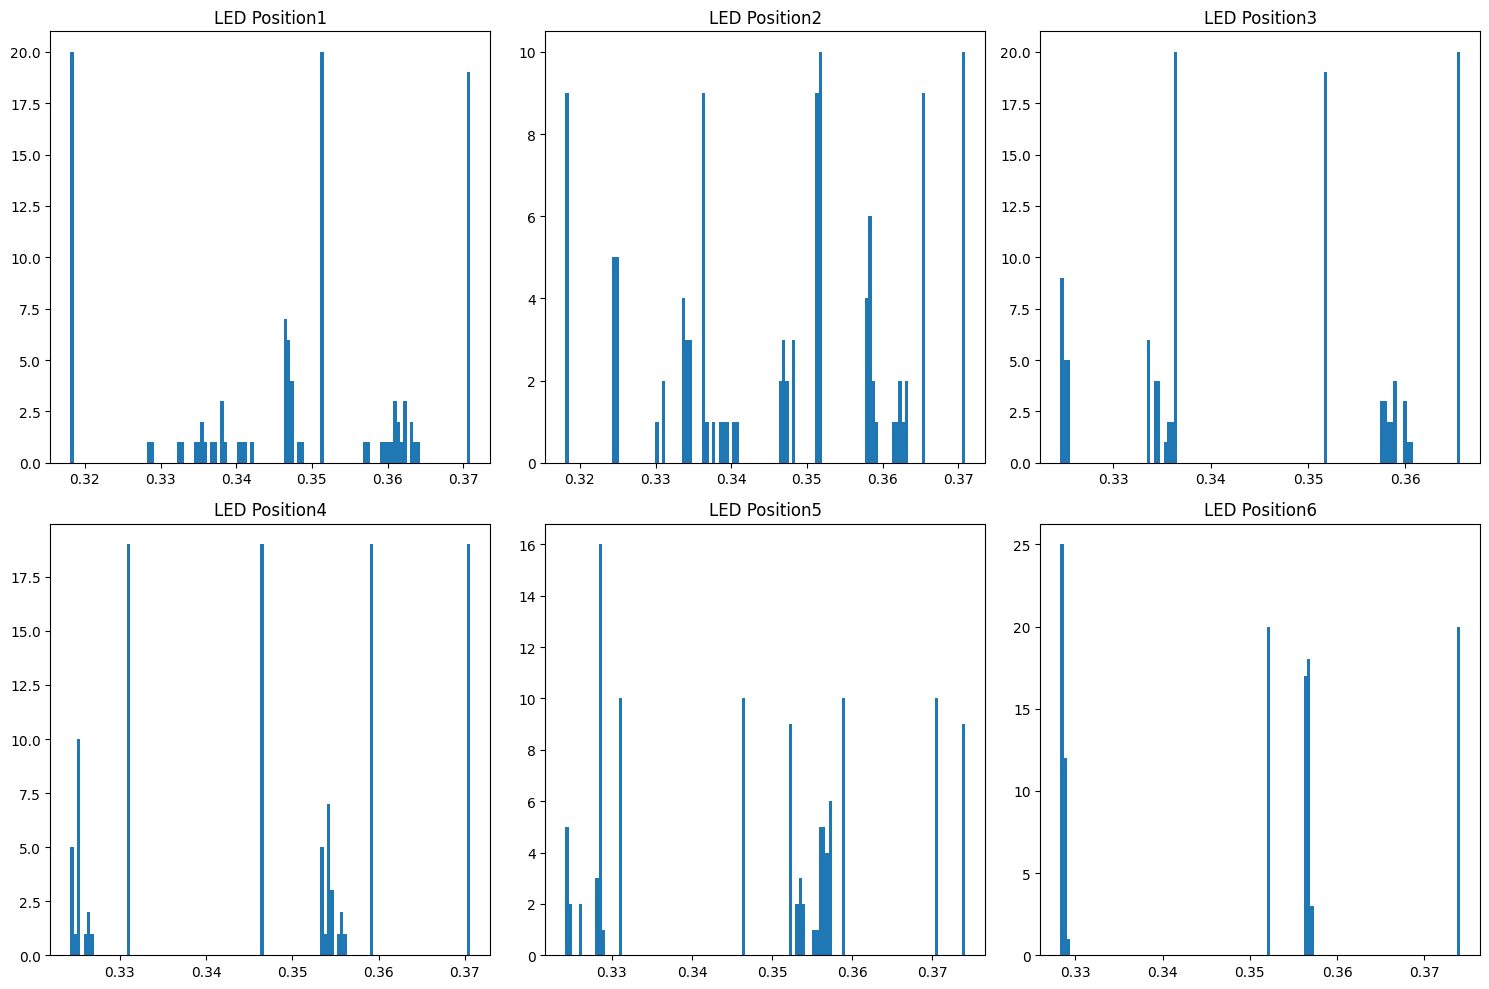

In [22]:
array = measurements.values #Creates a ndarray with the values of the dataframe
positions = []
for i, position in enumerate(range(glob.lenses_per_nest*2)):
    position = array[i::glob.lenses_per_nest*2].reshape(-1, 1)
    positions.append(position)
values_per_position = result_array = np.concatenate(positions, axis=1).reshape(glob.lenses_per_nest*2, -1)
fig, axes = plt.subplots(int(glob.lenses_per_nest*2/3), 3, figsize=(15, 10)) #subplots
for i in range(glob.lenses_per_nest*2): #Subplots definitions
    row, col = divmod(i, 3)
    ax = axes[row, col]
    ax.hist(values_per_position[i, :], 120)
    ax.set_title(f'LED Position{i + 1}')
plt.tight_layout()
plt.show()

Z-score filtering of outliers

![title](../media/Z-score.jpg)

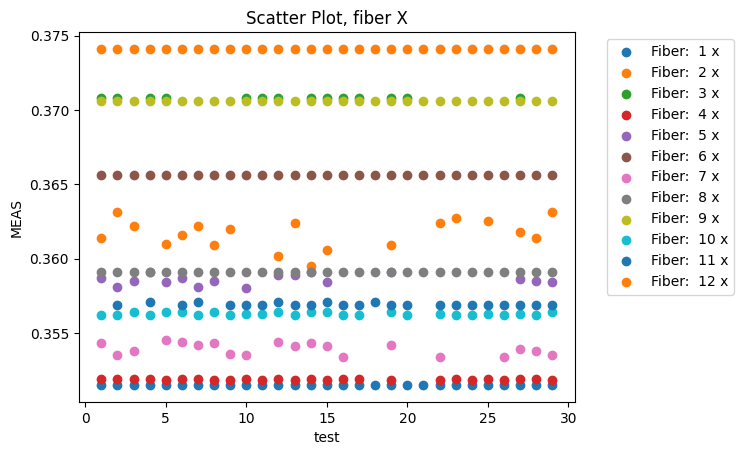

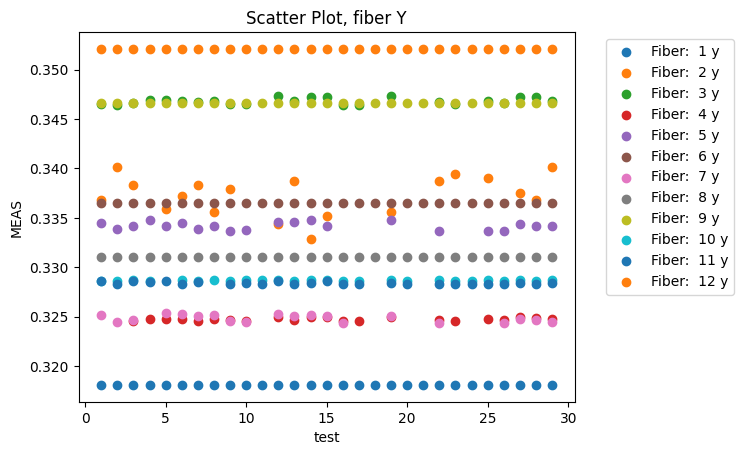

In [42]:
#Filter values by their row z-score
z_df = z_score_filter(measurements_and_limits, 1)
#Plot the filtered values
plot_scatter(z_df.iloc[:, :-2], 'Scatter Plot, fiber X', 'test', 'MEAS', 'Fiber: ', filter='x')
plot_scatter(z_df.iloc[:, :-2], 'Scatter Plot, fiber Y', 'test', 'MEAS', 'Fiber: ', filter='y')

In [43]:
#Split the dataframe for x fiber and y fiber
x_fiber = z_df.loc[z_df.index % 2 == 0]
y_fiber = z_df.loc[z_df.index % 2 != 0]
#Calculate the new RyR
RyRx_filtered, RyRy_filtered = RyR(z_df)

RyR Guide fbx 1: 1.0271586502546768e-12 % Status: Correct
RyR Guide fbx 2: 17.871893353423744 % Status: Low fail
RyR Guide fbx 3: 0.0 % Status: Correct
RyR Guide fbx 4: 0.9160572248285888 % Status: Correct
RyR Guide fbx 5: 6.359815506874243 % Status: Correct
RyR Guide fbx 6: 2.0543173005093536e-12 % Status: Correct
RyR Guide fbx 7: 7.1301820055871 % Status: Correct
RyR Guide fbx 8: 1.0271586502546768e-12 % Status: Correct
RyR Guide fbx 9: 1.0271586502546768e-12 % Status: Correct
RyR Guide fbx 10: 1.6498052210219296 % Status: Correct
RyR Guide fbx 11: 1.5085495163600295 % Status: Correct
RyR Guide fbx 12: 2.0543173005093536e-12 % Status: Correct

RyR Guide fby 1: 1.3558494183361712e-12 % Status: Correct
RyR Guide fby 2: 47.62166689538225 % Status: High fail
RyR Guide fby 3: 7.249107891140365 % Status: Correct
RyR Guide fby 4: 3.6233012141295315 % Status: Correct
RyR Guide fby 5: 9.221093830374592 % Status: Correct
RyR Guide fby 6: 4.067548255008513e-12 % Status: Correct
RyR Guide fby 7:

In [11]:
##Add both RyR to the database
confirmation = input("Do you want to export the new RyR to your database? (y/n): ").strip().lower()
if confirmation == 'y':
    RYR = pd.concat([RyRx, RyRy], axis=0).reset_index(drop=True)
    RYR_filtered = pd.concat([RyRx_filtered, RyRy_filtered], axis=0).reset_index(drop=True)
    prepare_database(RYR, glob.tooling+"_RyR") #Store a df inside the database of the project
    prepare_database(RYR_filtered, glob.tooling+"_RyR_filtered") #Store a df inside the database of the project
else:
    print("Operation canceled.")

Operation canceled.
